## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [620]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.model_selection import train_test_split
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [627]:
y = np.array(np.log(Data1['AvgDailyTrafficCount']) - np.log(Data1['AvgDailyTrafficCount']).mean())
X = np.array(Data1[['Longitude','Latitude']])

In [629]:
X_train = X[:800]
y_train = y[:800]

#### 2) The log marginal likelihood of the training data.

In [687]:
kernel = 0.712**2 * RBF(length_scale=0.0567, length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=0.599)

gpc_rbf = GaussianProcessRegressor(kernel=kernel).fit(X_train, y_train)

print (gpc_rbf.log_marginal_likelihood_value_)
print (gpc_rbf.kernel_)


-987.2049561006902
0.712**2 * RBF(length_scale=0.0567) + WhiteKernel(noise_level=0.599)


#### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

In [688]:
h = 0.01
lat_min, lat_max = X[:,1].min() - 0.01, X[:,1].max() + 0.01
lng_min, lng_max = X[:,0].min() - 0.01, X[:,0].max() + 0.01

lat,lng = np.meshgrid(np.arange(lat_min, lat_max, h),
                     np.arange(lng_min, lng_max, h))

x = [i for i in zip(lng.flat,lat.flat)]
z = gpc_rbf.predict(x)
z = z.reshape(len(np.arange(lng_min, lng_max, h)),len(np.arange(lat_min, lat_max, h)))

/Users/hemingyi/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'legend'
  s)
No handles with labels found to put in legend.


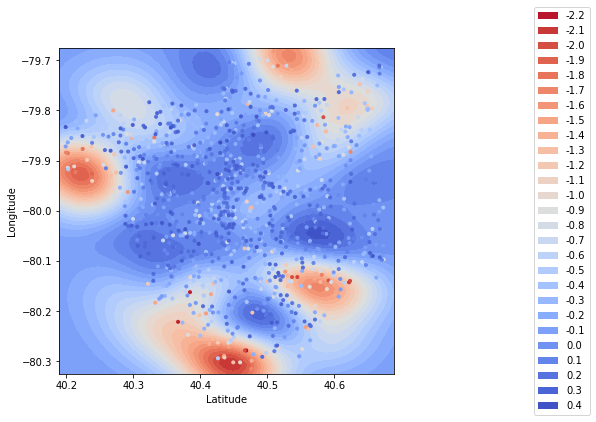

In [690]:
plt.figure(figsize=(6,6))
cs = plt.contourf(lat, lng, z, cmap='coolwarm_r',legend=True,levels=[round(i,2) for i in np.arange(-2.2, 0.6, 0.1).tolist()])
plt.scatter(X[:,1], X[:,0], c=y, cmap='coolwarm_r',marker='.')
proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

plt.legend(proxy, [round(i,2) for i in np.arange(-2.2, 0.6, 0.1).tolist()],bbox_to_anchor=(1.6, 0.5), loc='right', ncol=1)
plt.show()

#### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?

In [692]:
Data1['Processed'] = y
Data1['predict'] = gpc_rbf.predict(X)
std = Data1['predict'].std()
mean = Data1['predict'].mean()
anomaly = Data1[abs(Data1['Processed'] - mean) > 2 * std]
percent = len(anomaly)/len(Data1)
print('percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location')
print("{0:.0f}%".format(percent * 100))

percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location
43%


#### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values 
- a) more than two standard deviations higher than predicted, 
- b) more then two standard deviations lower than predicted, and 
- c) within two standard deviations of the predicted values. 

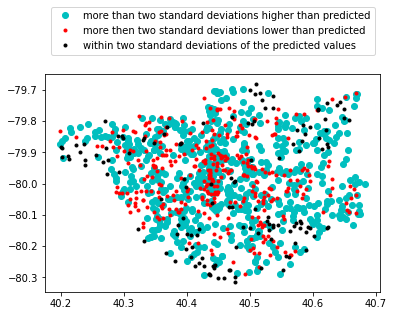

In [699]:
higher = Data1[(Data1['Processed'] - mean) > 2 * std]
lower = Data1[(Data1['Processed'] - mean) < -2 * std]
within = Data1[abs(Data1['Processed'] - mean) < 2 * std]
plt.plot(within['Latitude'],within['Longitude'],'co',label = 'more than two standard deviations higher than predicted')
plt.plot(higher['Latitude'],higher['Longitude'],'r.', label = 'more then two standard deviations lower than predicted')
plt.plot(lower['Latitude'],lower['Longitude'],'k.', label = 'within two standard deviations of the predicted values')
plt.legend(bbox_to_anchor=(1, 1.2), loc='right', ncol=1)


### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here
- (1,0) Anomaly. As this point is 10 std away from the center point, and the amount of 100 points is enough the support the conclude of a common distribution which this point is far away from.
- (35,2) Not Anomaly. The distance between (35,2) and (35,5) is less than 1 std, and the amount of 150 points is enough the support the conclude of a common distribution which this point is far away from.
- (15,19) Anomaly. The amount of cluster is 4 and the amount of point in cluster 3 is 2 which is less than 4. Thus, all the points belong to this cluster is anomaly.
- (10,11）Anomaly. The distance between (10,11) and (10,10) is l std of the data set, and the amount of 200 points is enough the support the conclude of a common distribution.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [301]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

In [586]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2 = Data2.replace('?',np.nan)
Data2 = Data2.dropna(how='any')

### Part 1

#### (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

In [587]:
Data3 = Data2.drop(['County'],axis=1)
Data3 = Data3.astype(np.float64)

In [588]:
DataProcessed = pd.DataFrame()
DataProcessed['Smoker'] = np.array(pd.cut(np.array(Data3["'\% Reporting Fair/Poor Health'"]),5,labels=[0,1,2,3,4]))
DataProcessed['Obese'] = np.array(pd.cut(np.array(Data3["'\% Obese'"]),5,labels=[0,1,2,3,4]))
DataProcessed['ViolentCrimeRate'] = np.array(pd.cut(np.array(Data3["'Violent Crime Rate'"]),5,labels=[0,1,2,3,4]))
DataProcessed['IncomeRatio'] = np.array(pd.cut(np.array(Data3["'80/20 Income Ratio'"]),5,labels=[0,1,2,3,4]))
DataProcessed['ChildrenInPoverty'] = np.array(pd.cut(np.array(Data3["'\% Children in Poverty'"]),5,labels=[0,1,2,3,4]))
DataProcessed['AverageDailyPM25'] = np.array(pd.cut(np.array(Data3["'Average Daily PM2.5'"]),5,labels=[0,1,2,3,4]))

In [589]:
hc = HillClimbSearch(DataProcessed, scoring_method=BicScore(DataProcessed))
model = hc.estimate()
print(model.edges())

[('Smoker', 'ChildrenInPoverty'), ('Smoker', 'Obese'), ('Smoker', 'AverageDailyPM25'), ('ChildrenInPoverty', 'IncomeRatio'), ('ChildrenInPoverty', 'ViolentCrimeRate')]


#### (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [590]:
MLE = MaximumLikelihoodEstimator(model, DataProcessed)
def loglikelihood(DataProcessed,MLE,model):
    likelihood = 1
    for node in model.nodes():
        Pnode = MLE.estimate_cpd(node).get_values()
        if model.get_parents(node) == []:
            Ppoint = Pnode[DataProcessed[node]]
            likelihood = likelihood * Ppoint
        else:
            parent = model.get_parents(node)
            for parentnode in parent:
                parentValue = DataProcessed[parentnode]
                Ppoint = Pnode[DataProcessed[node]][parentValue]
                likelihood = likelihood * Ppoint
    log_likelihood = np.log(likelihood)
    return log_likelihood[0]

In [591]:
result = DataProcessed
result['County'] = list(Data2['County'])
result['loglikelihood'] = result.apply(loglikelihood,MLE=MLE,model=model,axis=1)

In [593]:
print('The most abnormal counties')
Top5BN = list(result.sort_values(by=['loglikelihood']).iloc[:5]['County'])
print(Top5BN)

The most abnormal counties
['San Francisco, California', 'New York, New York', 'Suffolk, Massachusetts', 'District of Columbia, District of Columbia', 'Radford City, Virginia']


### Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

#### (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances.

In [569]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 

In [570]:
Data3 = Data2.drop(['County'],axis=1)
Data3 = Data3.astype(np.float64)
kmeans = KMeans(n_clusters=3, random_state=14).fit(Data3)

In [571]:
features = Data3.columns
Data3['label'] = kmeans.labels_
ClusterCenter = kmeans.cluster_centers_
def distance(Data3,ClusterCenter,features):
    label = int(Data3['label'])
    center = ClusterCenter[label]
    dis = 0
    for i,j in enumerate(features):
        dis += (Data3[j] - center[i]) ** 2
    dis = np.sqrt(dis)
    return dis

In [572]:
Data3['Distance'] = Data3.apply(distance,ClusterCenter=ClusterCenter,features=features,axis=1)

In [558]:
Data3['County'] = list(Data2['County'])
print('The most abnormal counties')
Top5KMeans = list(Data3.sort_values(by=['Distance']).iloch[-5:]['County'])
print(Top5KMeans)

The most abnormal counties
['Baltimore City, Maryland', 'Petersburg City, Virginia', 'Crittenden, Arkansas', 'St. Louis City, Missouri', 'Shannon, South Dakota']


#### (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness.

In [580]:
Data3 = Data2.drop(['County'],axis=1)
Data3 = Data3.astype(np.float64)
gm=GaussianMixture(n_components=3) 
gm.fit(Data3)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [581]:
Data3['loglikelihood'] = list(gm.score_samples(Data3))
Data3['County'] = list(Data2['County'])
print('The most abnormal counties')
Top5GM = list(Data3.sort_values(by=['loglikelihood']).iloc[:5]['County'])
print(Top5GM)

The most abnormal counties
['Shannon, South Dakota', 'Apache, Arizona', 'New York, New York', 'Willacy, Texas', 'Roulette, North Dakota']


#### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

#### isolation tree

In [582]:
from sklearn.ensemble import IsolationForest

In [583]:
Data3 = Data2.drop(['County'],axis=1)
Data3 = Data3.astype(np.float64)
clf = IsolationForest(behaviour='new', max_samples=100,
                      random_state=37, contamination='auto')
clf.fit(Data3)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
        max_features=1.0, max_samples=100, n_estimators=100, n_jobs=None,
        random_state=37, verbose=0)

In [563]:
Data3['anomaly'] = clf.score_samples(Data3)
Data3['County'] = list(Data2['County'])
print('The most abnormal counties')
Top5IT = list(Data3.sort_values(by=['anomaly']).iloc[:5]['County'])
print(Top5IT)

The most abnormal counties
['Shannon, South Dakota', 'Phillips, Arkansas', 'East Carroll, Louisiana', 'Roulette, North Dakota', 'Lowndes, Alabama']


#### Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous.

In [616]:
BNDF = pd.DataFrame()
BNDF['BN'] = [1,1,1,1,1]
BNDF.index = Top5BN

KMeansDF = pd.DataFrame()
KMeansDF['KMeans'] = [1,1,1,1,1]
KMeansDF.index = Top5KMeans

GMDF = pd.DataFrame()
GMDF['GM'] = [1,1,1,1,1]
GMDF.index = Top5GM

ITDF = pd.DataFrame()
ITDF['IT'] = [1,1,1,1,1]
ITDF.index = Top5IT

In [617]:
ITDF = ITDF.merge(KMeansDF,left_index=True,right_index=True, how='outer')
ITDF = ITDF.merge(GMDF,left_index=True,right_index=True, how='outer')
ITDF = ITDF.merge(BNDF,left_index=True,right_index=True, how='outer')
ITDF

,IT,KMeans,GM,BN
"Apache, Arizona",NaN,NaN,1.0,NaN
"Baltimore City, Maryland",NaN,1.0,NaN,NaN
"Crittenden, Arkansas",NaN,1.0,NaN,NaN
"District of Columbia, District of Columbia",NaN,NaN,NaN,1.0
"East Carroll, Louisiana",1.0,NaN,NaN,NaN
"Lowndes, Alabama",1.0,NaN,NaN,NaN
"New York, New York",NaN,NaN,1.0,1.0
"Petersburg City, Virginia",NaN,1.0,NaN,NaN
"Phillips, Arkansas",1.0,NaN,NaN,NaN
"Radford City, Virginia",NaN,NaN,NaN,1.0


### Conclusion
- Shannon in South Dakota has to be the most abnormal point, as it is detected in all the three different models.
- New York City and san Fransico are nearly different all the other cities in United States, it is no suprising that these two cities being detected as anomaly.